In [1]:
# code here
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
# disable tex formatting (for Linux)
rcParams["text.usetex"] = False
import matplotlib.pyplot as plt

import numpy as np
import theano.tensor as tt
import pymc3 as pm

deg = np.pi/180.0

In [2]:
def calc_theta(i_disk, Omega_disk, i_star, Omega_star):
    '''
    Calculate the mutual inclination between two planes. Assumes all inputs in degrees.
    '''
    
    cos_theta = np.cos(i_disk * deg) * np.cos(i_star * deg) + \
        np.sin(i_disk * deg) * np.sin(i_star * deg) * np.cos((Omega_disk - Omega_star) * deg)
    theta = np.arccos(cos_theta)/deg
    
    return theta

V4046 Sgr : $M \sin^3 i_\star = 0.2923 \pm 0.0007$ $M = 1.75 \pm 0.08\,M_\odot$ $i_\star = 33.42^\circ \pm 0.58^\circ$ and $i_\mathrm{disk} = 33.5^\circ \pm 1.4^\circ$ 

AK Sco: $M \sin^3 i_\star = 2.114 \pm 0.01\,M_\odot$, $M = 2.49\pm 0.10\,M_\odot$

DQ Tau: $M \sin^3 i_\star = 0.0647 \pm 0.0033\,M_\odot$. $M = 1.27^{+0.46}_{-0.27}\,M_\odot$

UZ Tau E: $M \sin^3 i_\star = 0.75 \pm 0.10$ $M = 1.21 \pm 0.09\,M_\odot$

UZ Tau E: $M \sin^3 i_\star = 0.69 \pm 0.13$ $M = 1.21 \pm 0.05\,M_\odot$

Let $x = M \sin^3 i_\star$.

$$
i_\star = \sin^{-1} \left [\left ( \frac{x}{M} \right)^{1/3} \right ]
$$

In [3]:
# MC code to convert uncertainty on M sin^3 i and M to uncertainty on i_star
xs = np.random.normal(loc=0.69, scale=0.13, size=10000)
Ms = np.random.normal(loc=1.21, scale=0.05, size=10000)
q = (xs/Ms)**(1/3)
j = q[(q > -1) & (q < 1)]
i_stars = np.arcsin(j)/deg

56.0967298191046
5.6972593454137685


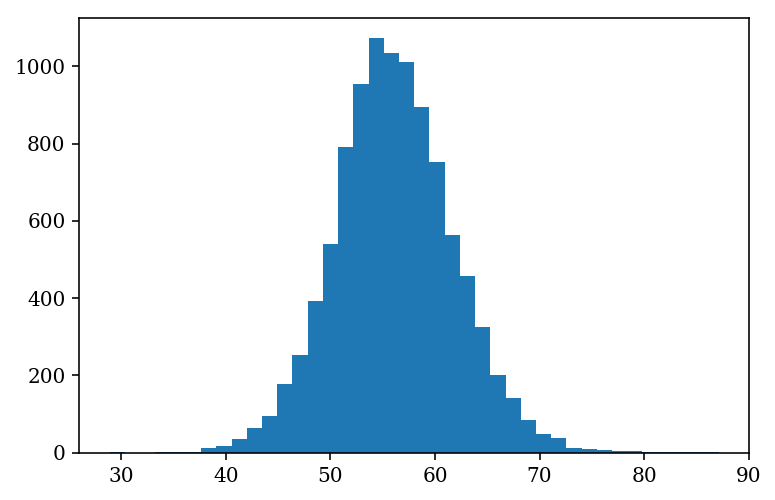

In [4]:
print(np.mean(i_stars))
print(np.std(i_stars))
plt.hist(i_stars, bins=40);

In [5]:
def get_i_star(M, M_err, x, x_err):
    i_star = np.arcsin((x/M)**(1/3))/deg
        
    return i_star
                 
print(get_i_star(2.49, 0.10, 2.114, 0.01))
print(get_i_star(1.27, 0.35, 0.0647, 0.0033))
print(get_i_star(1.21, 0.09, 0.75, 0.10))

71.24376075661917
21.759370328104644
58.49845953759619


In [3]:
# create tables of all of these things as datasets
from astropy.table import Table

# table of stars with inclinations and uncertainties
# name, #i_disk, i_disk_err, i_star, i_star_err (deg)
rows = [("V4046Sgr", 33.5, 1.4, 33.42, 0.58),
("AKSco", 109.4, 0.5, 108.76, 2.4 ),
("DQ Tau", 160.0, 3.0, 158.24, 2.77),
("UZ Tau E", 56.15, 1.5, 58.6, 5.0)]

sample = Table(rows=rows, names=["name", "i_disk", "i_disk_err", "i_star", "i_star_err"])

In [4]:
sample

name,i_disk,i_disk_err,i_star,i_star_err
str8,float64,float64,float64,float64
V4046Sgr,33.5,1.4,33.42,0.58
AKSco,109.4,0.5,108.76,2.4
DQ Tau,160.0,3.0,158.24,2.77
UZ Tau E,56.15,1.5,58.6,5.0


In [5]:
sd_disk = np.sin(sample["i_disk"].data * deg) * sample["i_disk_err"].data * deg
sd_star = np.sin(sample["i_star"].data * deg) * sample["i_star_err"].data * deg
N_systems = 4

In [6]:
sd_star

array([0.00557542, 0.03966257, 0.01792267, 0.07448636])

In [7]:
# instantiate a PyMC3 model class 
with pm.Model() as model:

    alpha = pm.Uniform("alpha", lower=1.0, upper=50.0)
    beta = pm.Uniform("beta", lower=1.0, upper=50.0)

    v = pm.Beta("v", alpha=alpha, beta=beta, shape=N_systems)    

    theta = pm.Deterministic("theta", v * 180.)
    
    # Convert from the intermediate variable to the actual mutual inclination angles we
    cos_theta = tt.cos(v * np.pi)
    sin_theta = tt.sin(v * np.pi)
    
    # Enforce the geometrical prior on i_disk, as before
    # Testval tells the chain to start in the center of the posterior.
    cos_i_disk = pm.Uniform("cosIdisk", lower=-1.0, upper=1.0, shape=N_systems, \
                            testval=np.cos(sample["i_disk"].data * deg)) 
    # helper variable
    sin_i_disk = tt.sqrt(1.0 - cos_i_disk**2)

    # This is the azimuthal orientation of the binary vector on the circle some theta away 
    phi = pm.Uniform("phi", lower=-np.pi/2.0, upper=np.pi/2.0, shape=N_systems)
    
    cos_i_star = pm.Deterministic("cos_i_star", -sin_i_disk * sin_theta * tt.sin(phi) + \
                                  cos_i_disk * cos_theta)
    
    # Finally, we define the likelihood by conditioning on the observations using a Normal
    obs_disk = pm.Normal("obs_disk", mu=cos_i_disk, sd=sd_disk, observed=np.cos(sample["i_disk"].data * deg))
    obs_star = pm.Normal("obs_star", mu=cos_i_star, sd=sd_star, observed=np.cos(sample["i_star"].data * deg))

In [10]:
# sample the model!
with model:
    trace = pm.sample(draws=10000, tune=20000, chains=2, nuts_kwargs={"target_accept":0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [phi, cosIdisk, v, beta, alpha]
Sampling 2 chains: 100%|██████████| 60000/60000 [04:31<00:00, 220.97draws/s]
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1be4c8d0>,
      dtype=object)

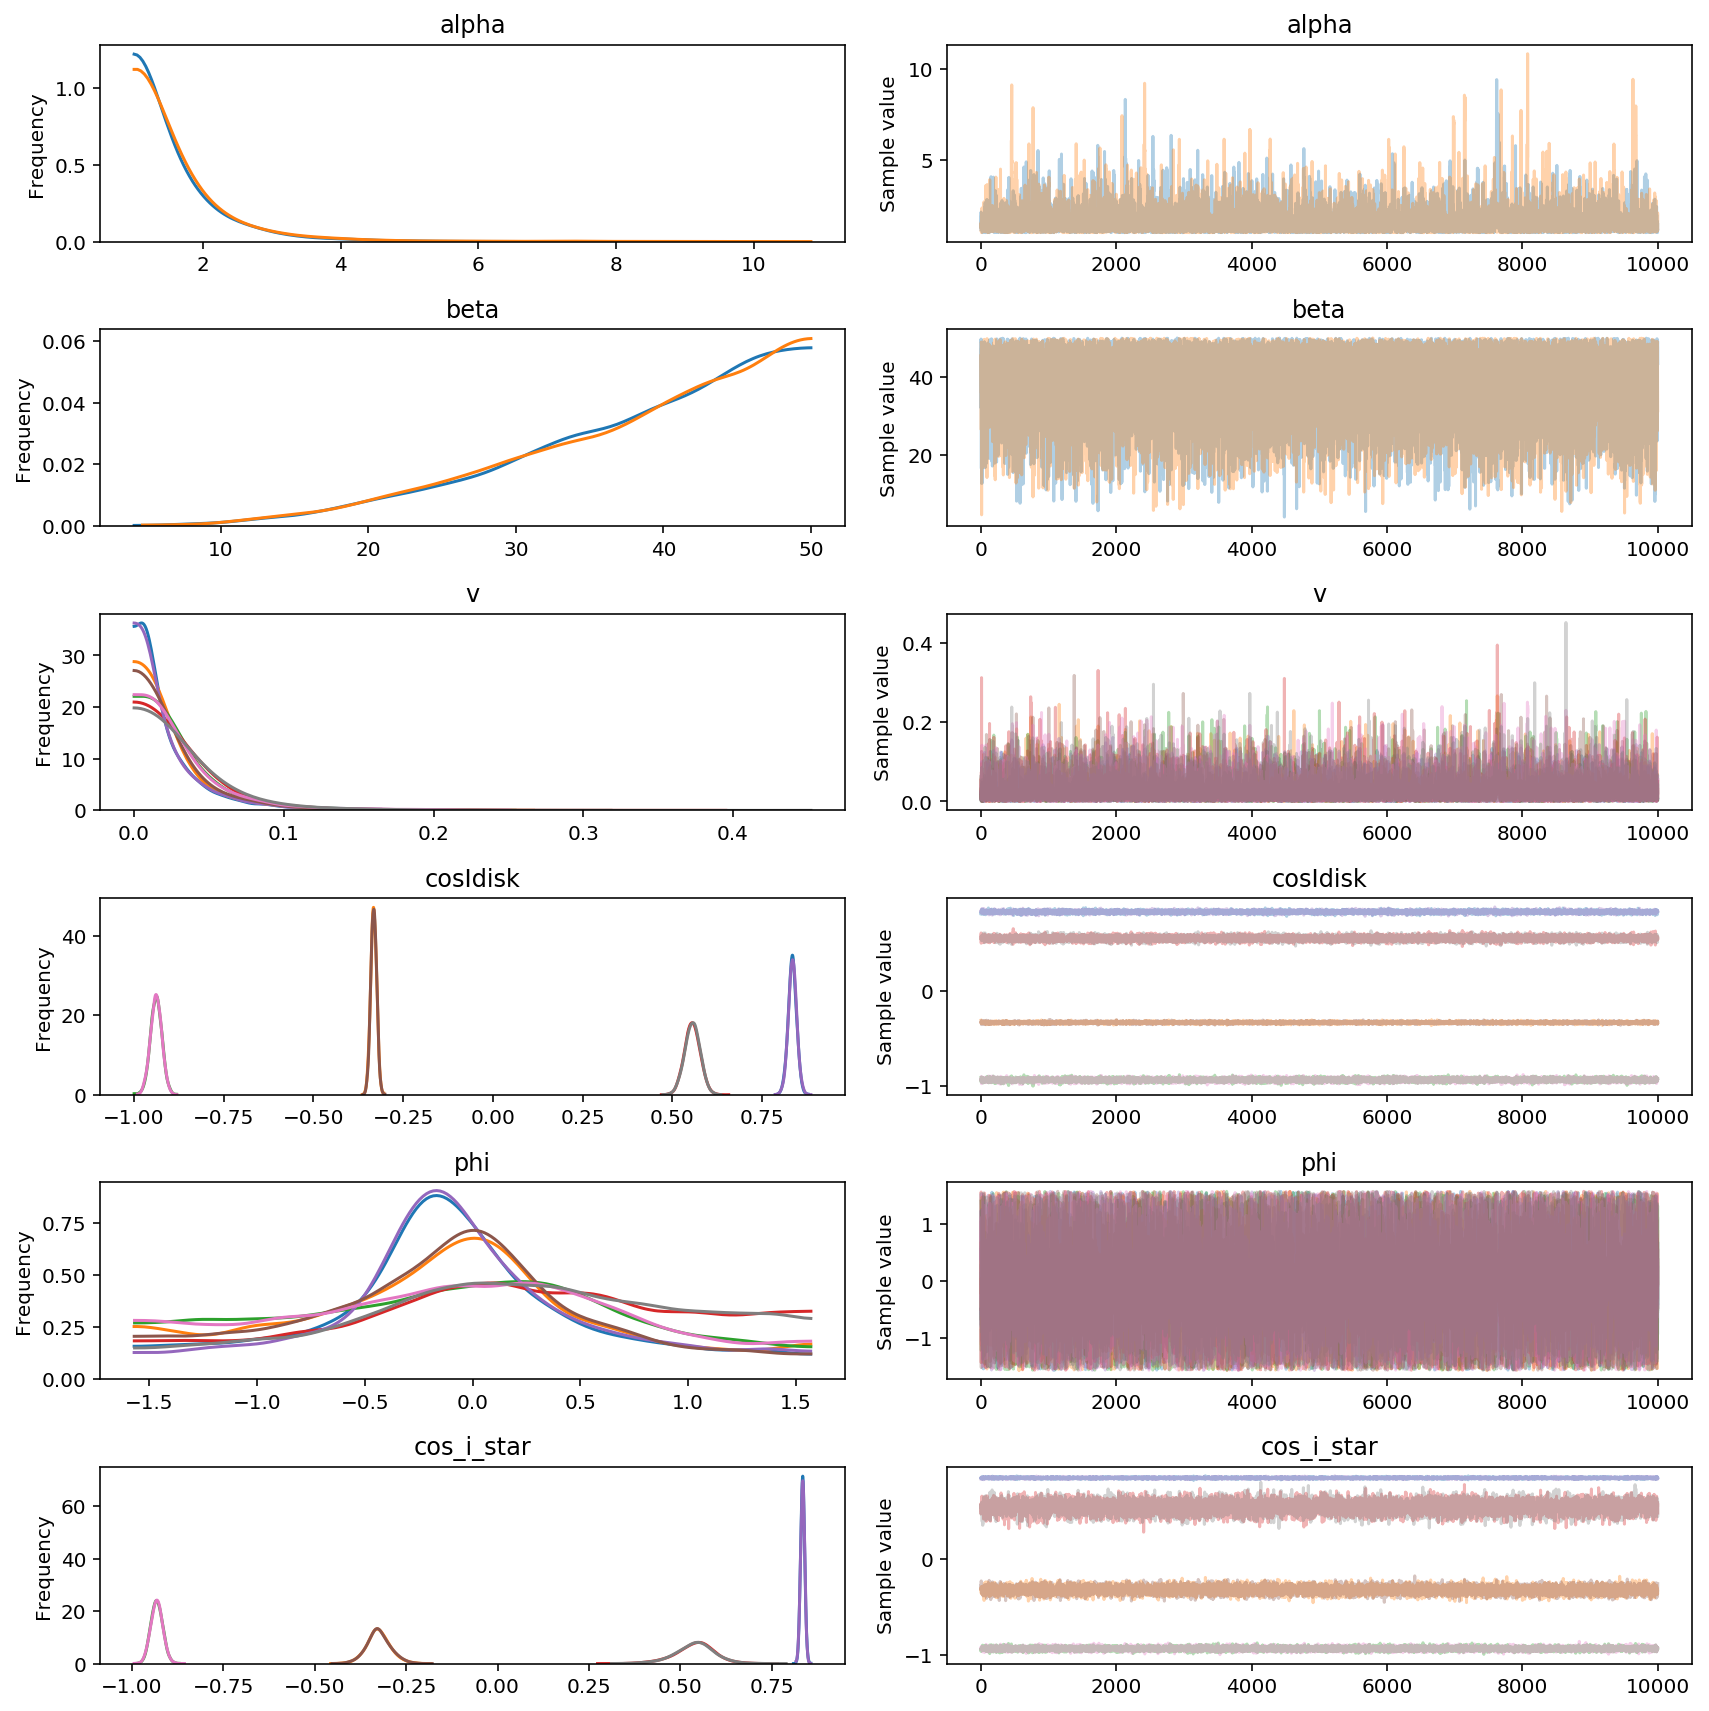

In [11]:
pm.traceplot(trace)

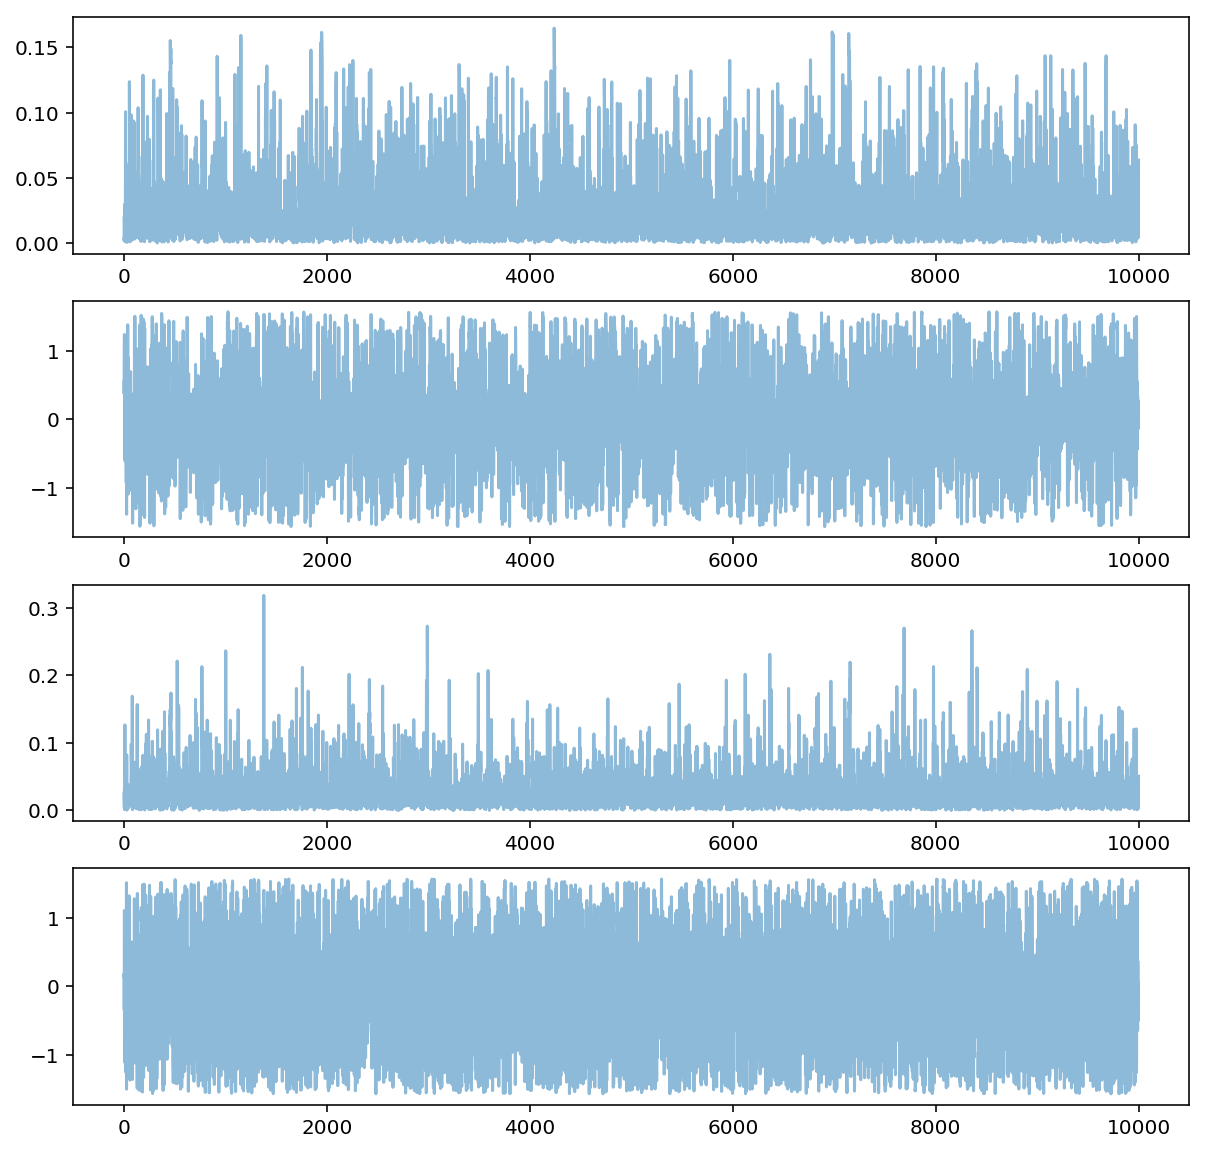

In [12]:
fig, axs = plt.subplots(nrows=4, figsize=(10,10))
axs[0].plot(trace.get_values('v', chains=1)[:,0], alpha=.5);
# axs[0].set(ylabel='sigma_b');
axs[1].plot(trace.get_values('phi', chains=1)[:,0], alpha=.5);
# axs[1].set(ylabel='b');

axs[2].plot(trace.get_values('v', chains=1)[:,1], alpha=.5);
# axs[0].set(ylabel='sigma_b');
axs[3].plot(trace.get_values('phi', chains=1)[:,2], alpha=.5);


(<matplotlib.axes._subplots.AxesSubplot at 0x1c35684f60>, GridSpec(17, 17))

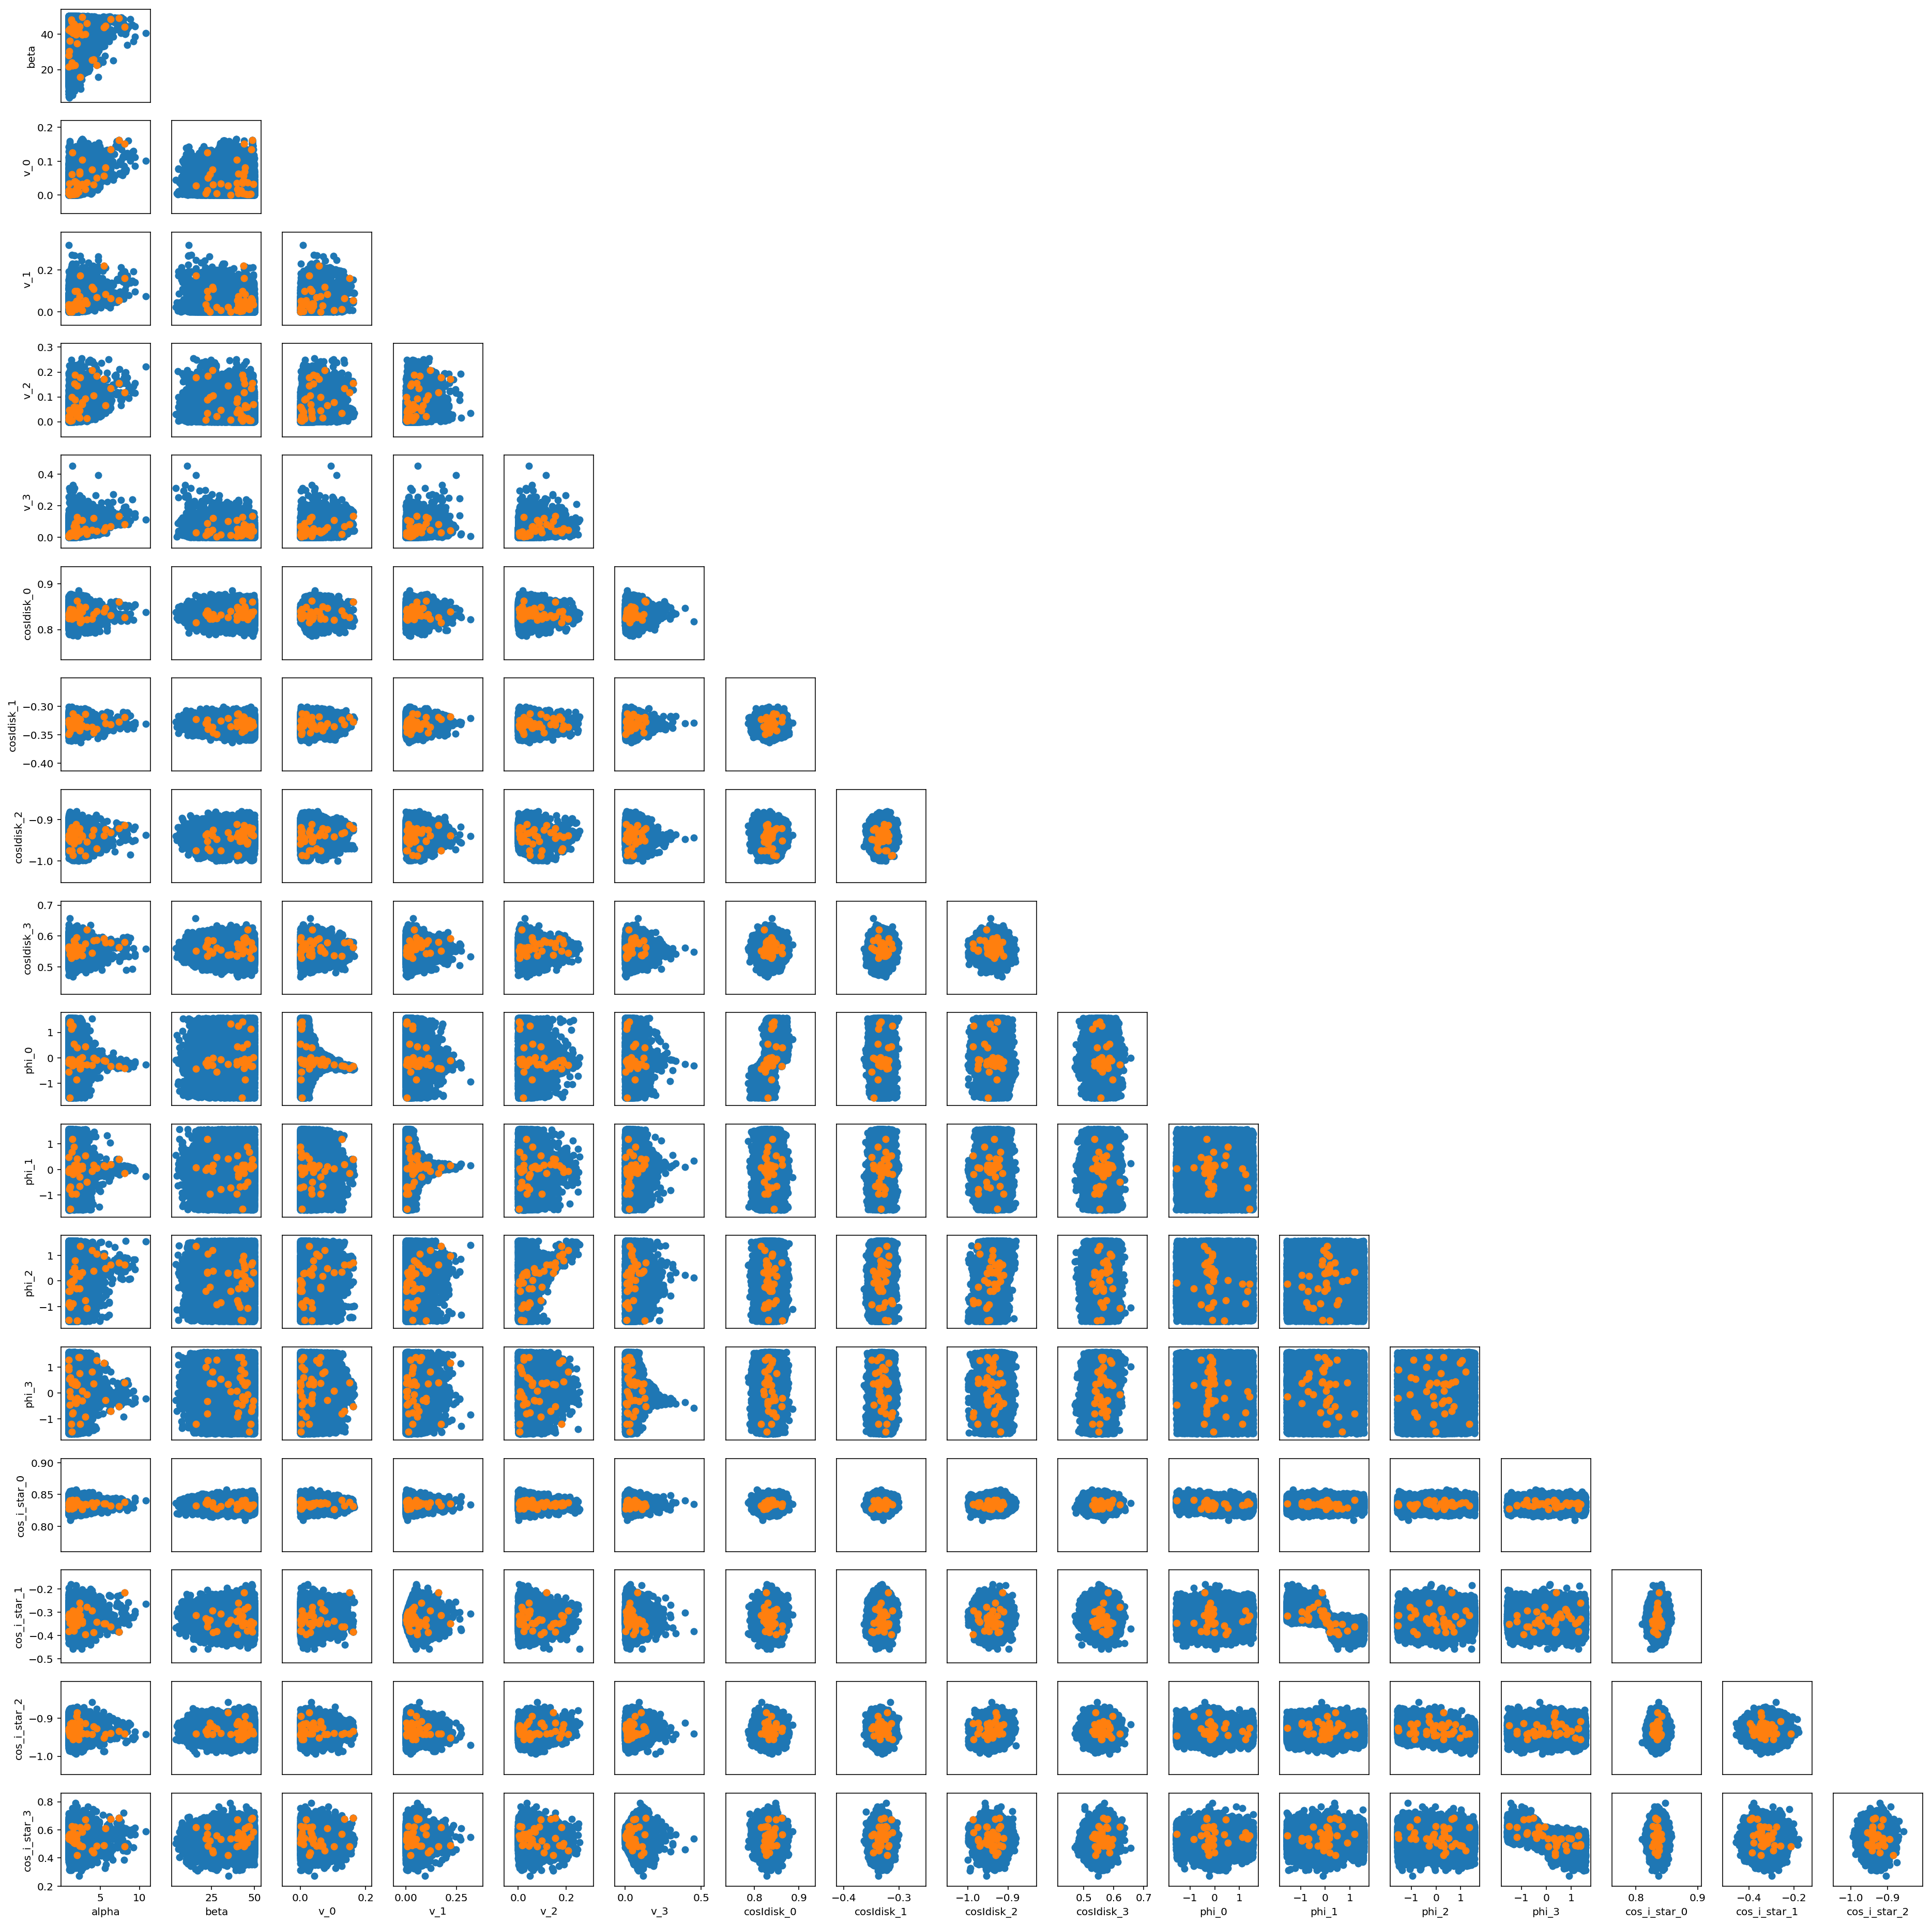

In [14]:
pm.pairplot(trace,
#             sub_varnames=[variable_1, variable_2],
            divergences=True,
            color='C0',
            kwargs_divergence={'color': 'C1'})

I think the problem of divergences comes from the "funnel" aspect of hierarchical models, but probably in a different manner than most problems. Usually, the problem manifests itself when a parameter at the top of the hierarchy puts a strong constraint on the individual-level (or group) parameters. For example, [the slope of each line](https://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/) or the [performance of a school](https://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html). Basically, there is a tradeoff between this hyperparameter saying everyone should have the same group-level parameters and that everyone can have whatever parameter they want.

I think the phenomenology is the same but the reasons are a little different for us. Our hyperparameter is what $\theta$ should be. Since we specify normal distributions on the observed values of $\cos i_\mathrm{disk}$ and $\cos i_\star$, a value of $\theta$ has an influence of how wide the space on $\theta$ is. For example, if $\theta$ is small, then there are a wide range of $\phi$ values for each disk that fit $\cos i_\mathrm{disk}$ and $\cos i_\star$ within the errors. But, if $\theta$ is large, then there really is only a single orientation of $\phi$ with that value of $\theta$ that will fit both $\cos i_\mathrm{disk}$ and $\cos i_\star$.

To go to larger $x$, we really need to squeeze $\phi$ into a narrow range.

So, if the advice is to "reparameterize" what can we change here to remove some of the multidimensional pathologies?

Rather than sampling in $\phi$ directly, is there something we can do to sample *around* the value of $\phi$ implied by coplanarity, and then recover $\phi$ by some scaling?

Basically, we can say that whatever the mean of $\theta$ is for the whole sample, and then 

What if we start off saying that we assume intercept values $\cos i_\mathrm{disk}$ and $\cos i_\star$ that are fixed to the means for each disk. Then, we draw a mutual inclination value $\theta$ and calculate the $\phi$ implied by this, calling it $\phi_0$ or something. Then, we draw randomly from [0, 360] around this value, and evaluate the proposal for $\phi$, calling it $\phi$-offset or something. Will this still have the same bad behavior? 

Well, most $\phi$-offsets should be pretty close to 0, I think. Only for the largest $\theta$ values will $\phi$-offset need to be very small. Anyway, it's worth coding it up and seeing what happens, I guess.

Maybe thinking about it in terms of delta cos i? If \theta is small, then we know that the final cos i is going to be small and close to i_disk. But, if it's large, then, 

# Mutual inclination distribution

First, let's try sampling in $\mu$ and $\sigma$ for the $\beta$ distribution rather than $\alpha$ and $\beta$. These two parameters are quite correlated so maybe it's not the best.

The mean of the $\beta$ distribution is given by 

$$
\mu = \frac{1}{1 + \frac{\beta}{\alpha}}
$$

and the variance 

$$
\sigma^2 = \frac{\alpha \beta}{(\alpha + \beta)^2(\alpha + \beta + 1)}
$$

Instead, we can parameterize the distribution in terms of its mean $\mu$ and sample size $\nu = \alpha + \beta$ where ($\nu > 0$).

$$
\alpha = \mu \nu
$$

$$
\beta = (1 - \mu) \nu
$$

and the variance

$$
\sigma^2 = \frac{\mu (1 - \mu)}{1 + \nu}
$$

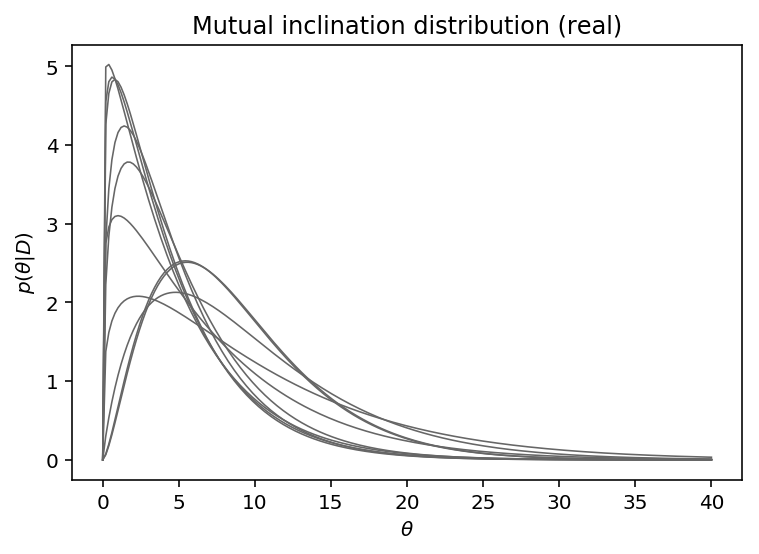

In [17]:
N_realizations = 10

N_samples = len(trace)
ind = np.random.choice(range(N_samples), size=N_realizations)
alphas = trace["alpha"][ind]
betas = trace["beta"][ind]

thetas = np.linspace(0, 40, num=200)
vs = thetas / 180.0 # map to [0,1]

fig, ax = plt.subplots(nrows=1)

for (alpha, beta) in zip(alphas, betas):
    y = pm.Beta.dist(alpha=alpha, beta=beta) # query the PyMC3 implementation
    ys = np.exp(np.array([y.logp(v).eval() for v in vs])) / np.pi
    
    ax.plot(thetas, ys, lw=0.8, color="0.4")
    
ax.set_xlabel(r"$\theta$");
ax.set_ylabel(r"$p(\theta|D)$");
ax.set_title("Mutual inclination distribution (real)");

In [12]:
# instantiate a PyMC3 model class 
with pm.Model() as marginal_model:
        
    alpha = pm.Uniform("alpha", lower=1.0, upper=50)
    beta = pm.Uniform("beta", lower=1.0, upper=50)
    v = pm.Beta("v", alpha=alpha, beta=beta, shape=N_systems)    

    # Convert from the intermediate variable to the actual mutual inclination angle we want
    cos_theta = tt.cos(v * np.pi)
    sin_theta = tt.sin(v * np.pi)
    
    # Enforce the geometrical prior on i_disk, as before
    # Testval tells the chain to start in the center of the posterior.
    cos_i_disk = pm.Uniform("cosIdisk", lower=-1.0, upper=1.0, shape=N_systems, \
                            testval=np.cos(sample["i_disk"].data * deg)) 
    
    sin_i_disk = tt.sqrt(1.0 - cos_i_disk**2)
    
    # intermediate cos_i_star variable 
    y = pm.Uniform("y", lower=0.0, upper=1.0, shape=N_systems)
    
    # calculate cos_i_star from cos_i_disk, theta, and intermediate variable y
    # the fact that we have used the intermediate variable y ensures that
    # we have an allowable cos_i_star for our prior
    cos_i_star = pm.Deterministic("cosIstar", cos_i_disk * cos_theta - sin_i_disk * sin_theta + \
                                 ((sin_i_disk * sin_theta + cos_i_disk * cos_theta) - \
                                  (cos_i_disk * cos_theta - sin_i_disk * sin_theta)) * y)    

#     cos_i_star = pm.Uniform("cosIstar", lower=-1.0, upper=1.0, shape=N_systems, \
#                            testval=np.cos(sample["i_star"].data * deg))

    # get the high and low bounds of the model 
#     low = cos_i_disk * cos_theta - sin_i_disk * sin_theta
#     high = sin_i_disk * sin_theta + cos_i_disk * cos_theta

#     prior_val = tt.switch(tt.and_(tt.lt(low, cos_i_star), tt.lt(cos_i_star, high)), -pm.math.log(sin_i_disk) - pm.math.log(sin_theta) - \
#         0.5 * pm.math.log(1 - ((cos_i_disk * cos_theta - cos_i_star)/(sin_i_disk * sin_theta))**2), -1)

#     tt.printing.Print("cosIdisk")(cos_i_disk)
#     tt.printing.Print("cos_theta")(cos_theta)
#     tt.printing.Print("low")(low)
#     tt.printing.Print("high")(high)
#     tt.printing.Print("cosIstar")(cos_i_star)
#     tt.printing.Print("prior_val")(prior_val)
    
    # get the low and high values of the bounds and apply the marginal prior as a potential
    # calculate the prior on cos_i_star using potential
#     pm.Potential("cosIPrior", tt.switch(tt.and_(tt.lt(low, cos_i_star), tt.lt(cos_i_star, high)), -pm.math.log(sin_i_disk) - pm.math.log(sin_theta) - \
#         0.5 * pm.math.log(1 - ((cos_i_disk * cos_theta - cos_i_star)/(sin_i_disk * sin_theta))**2), -100))
    pm.Potential("cosIPrior", -pm.math.log(sin_i_disk) - pm.math.log(sin_theta) - \
        0.5 * pm.math.log(1 - ((cos_i_disk * cos_theta - cos_i_star)/(sin_i_disk * sin_theta))**2))

    # Finally, we define the likelihood by conditioning on the observations using a Normal
    obs_disk = pm.Normal("obs_disk", mu=cos_i_disk, sd=sd_disk, observed=np.cos(sample["i_disk"].data * deg))
    obs_star = pm.Normal("obs_star", mu=cos_i_star, sd=sd_star, observed=np.cos(sample["i_star"].data * deg))

$$
\cos i_\mathrm{disk} \cos \theta - \sin i_\mathrm{disk} \sin \theta < \cos i_\star < \sin i_\mathrm{disk} \sin \theta + \cos i_\mathrm{disk} \cos \theta
$$

In [13]:
# sample the model!
with marginal_model:
    marginal_trace = pm.sample(draws=2000, tune=10000, chains=2) #, nuts_kwargs={"target_accept":0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y, cosIdisk, x, beta, alpha]
Sampling 2 chains: 100%|██████████| 24000/24000 [03:05<00:00, 129.38draws/s]
There were 308 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7051009262905285, but should be close to 0.8. Try to increase the number of tuning steps.
There were 199 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/ian/.build/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94966de320>,
      dtype=object)

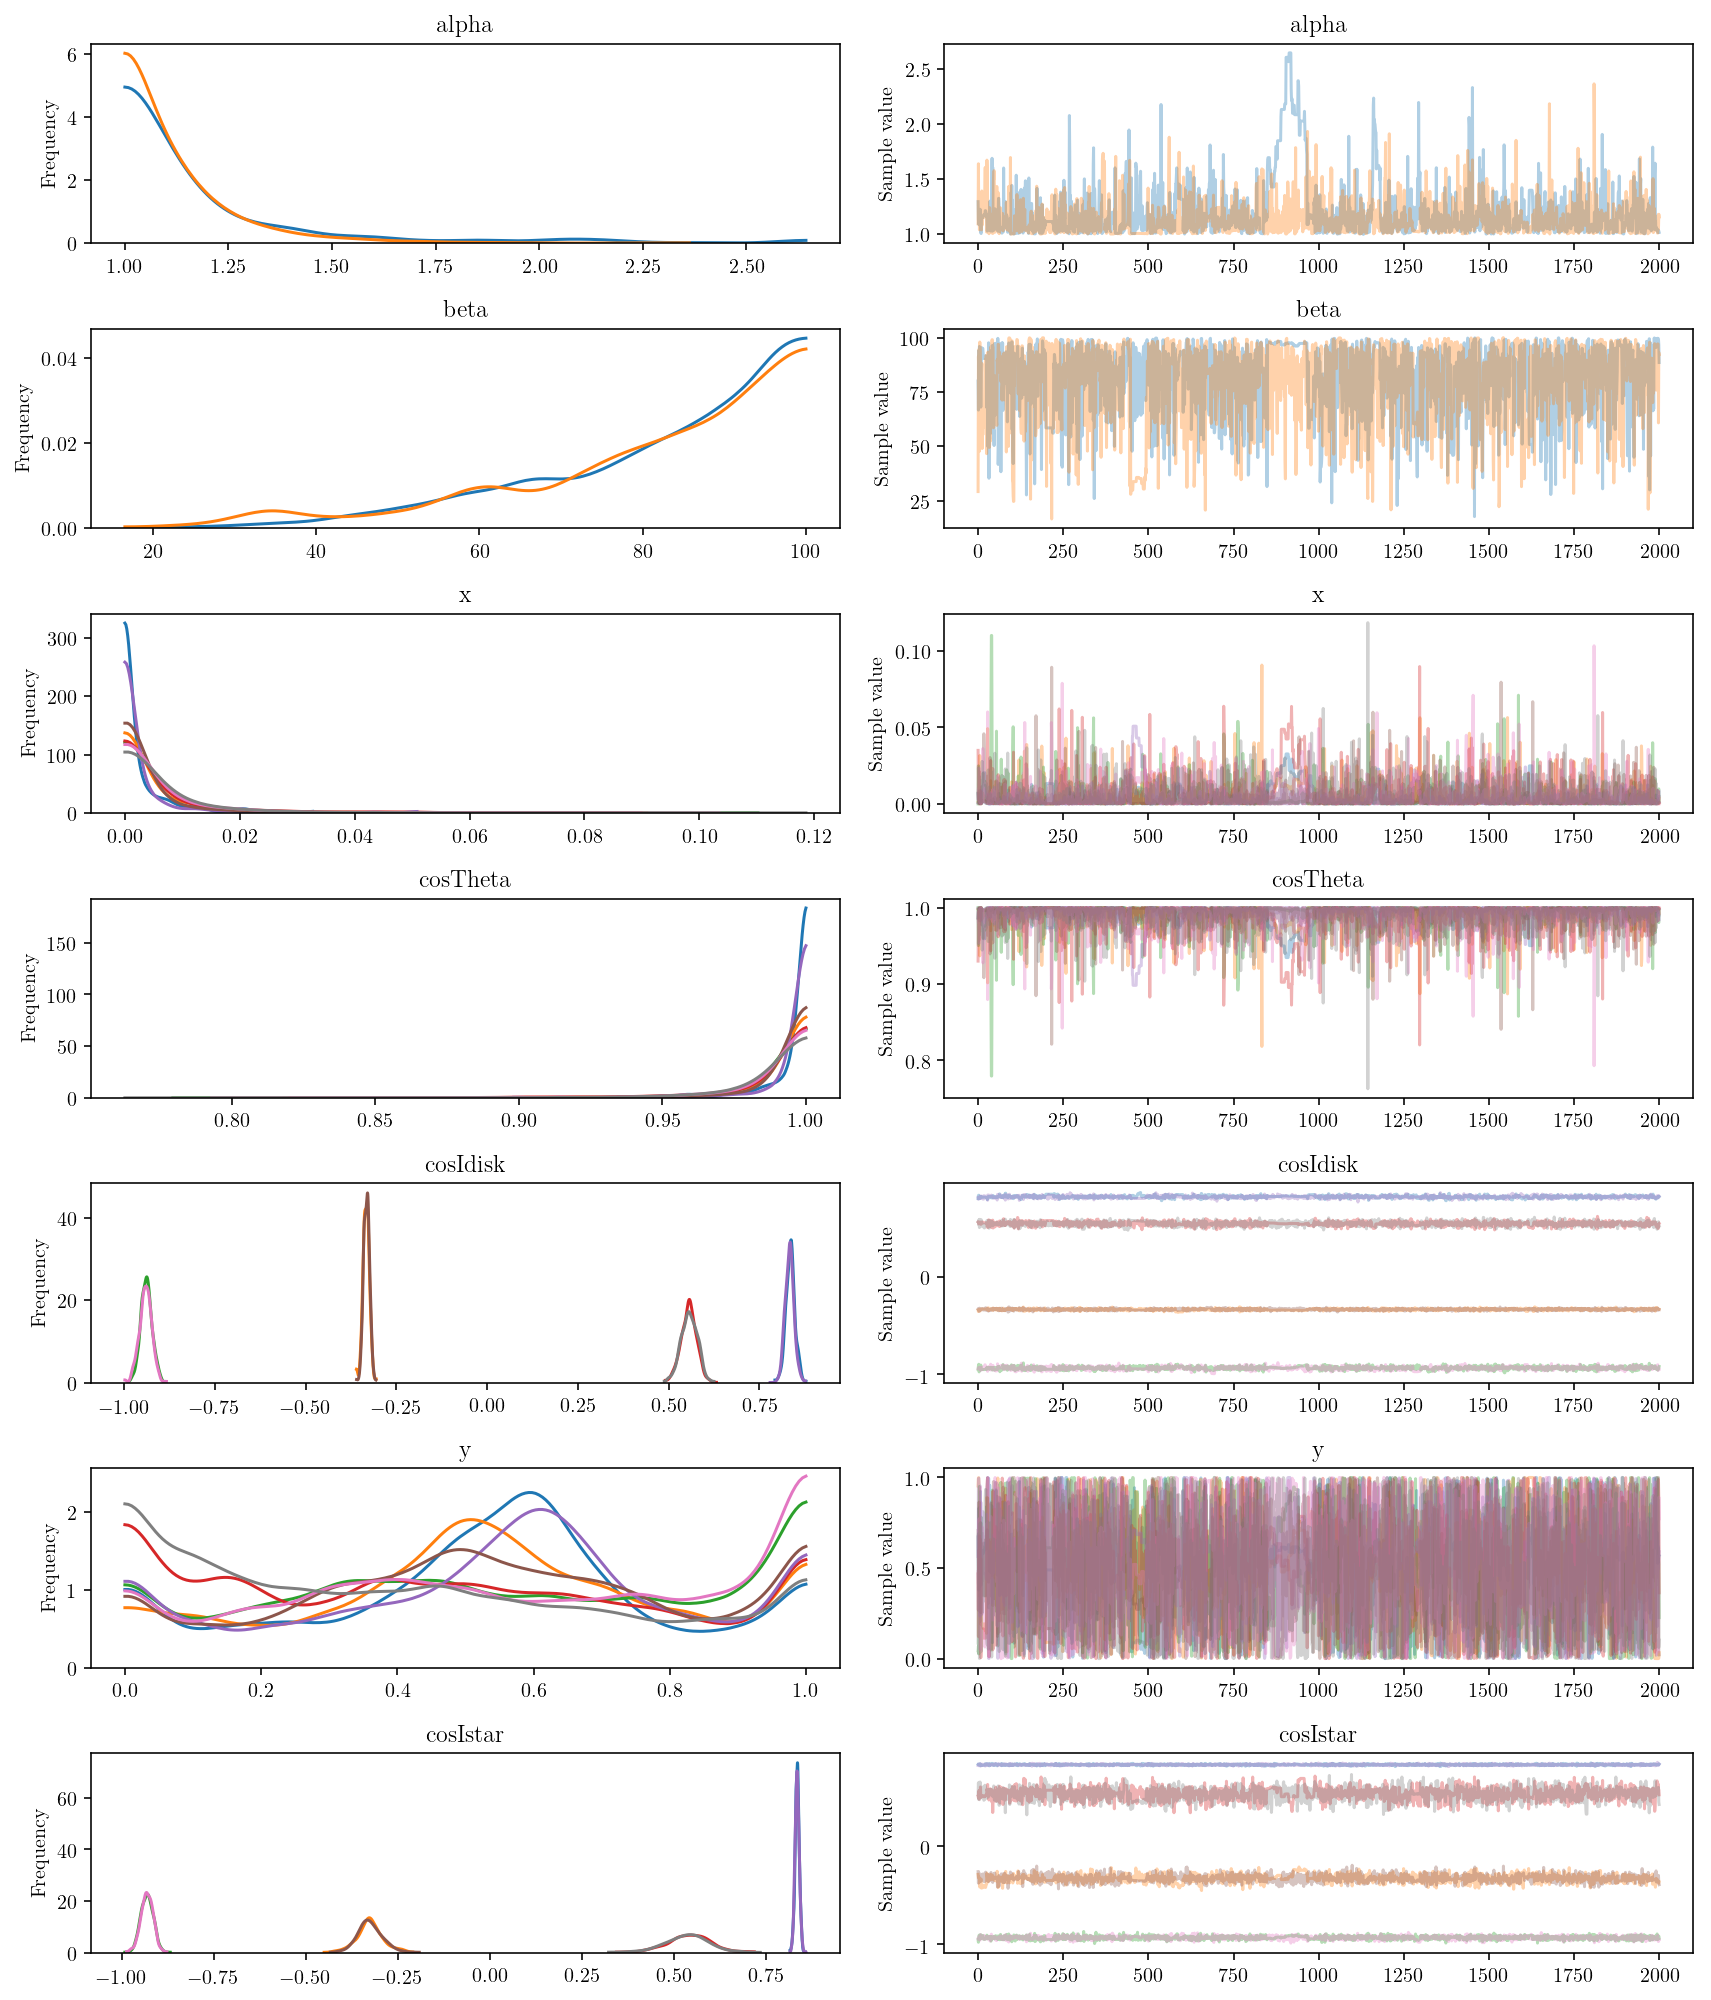

In [14]:
pm.traceplot(marginal_trace)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f948b8fd550>, GridSpec(21, 21))

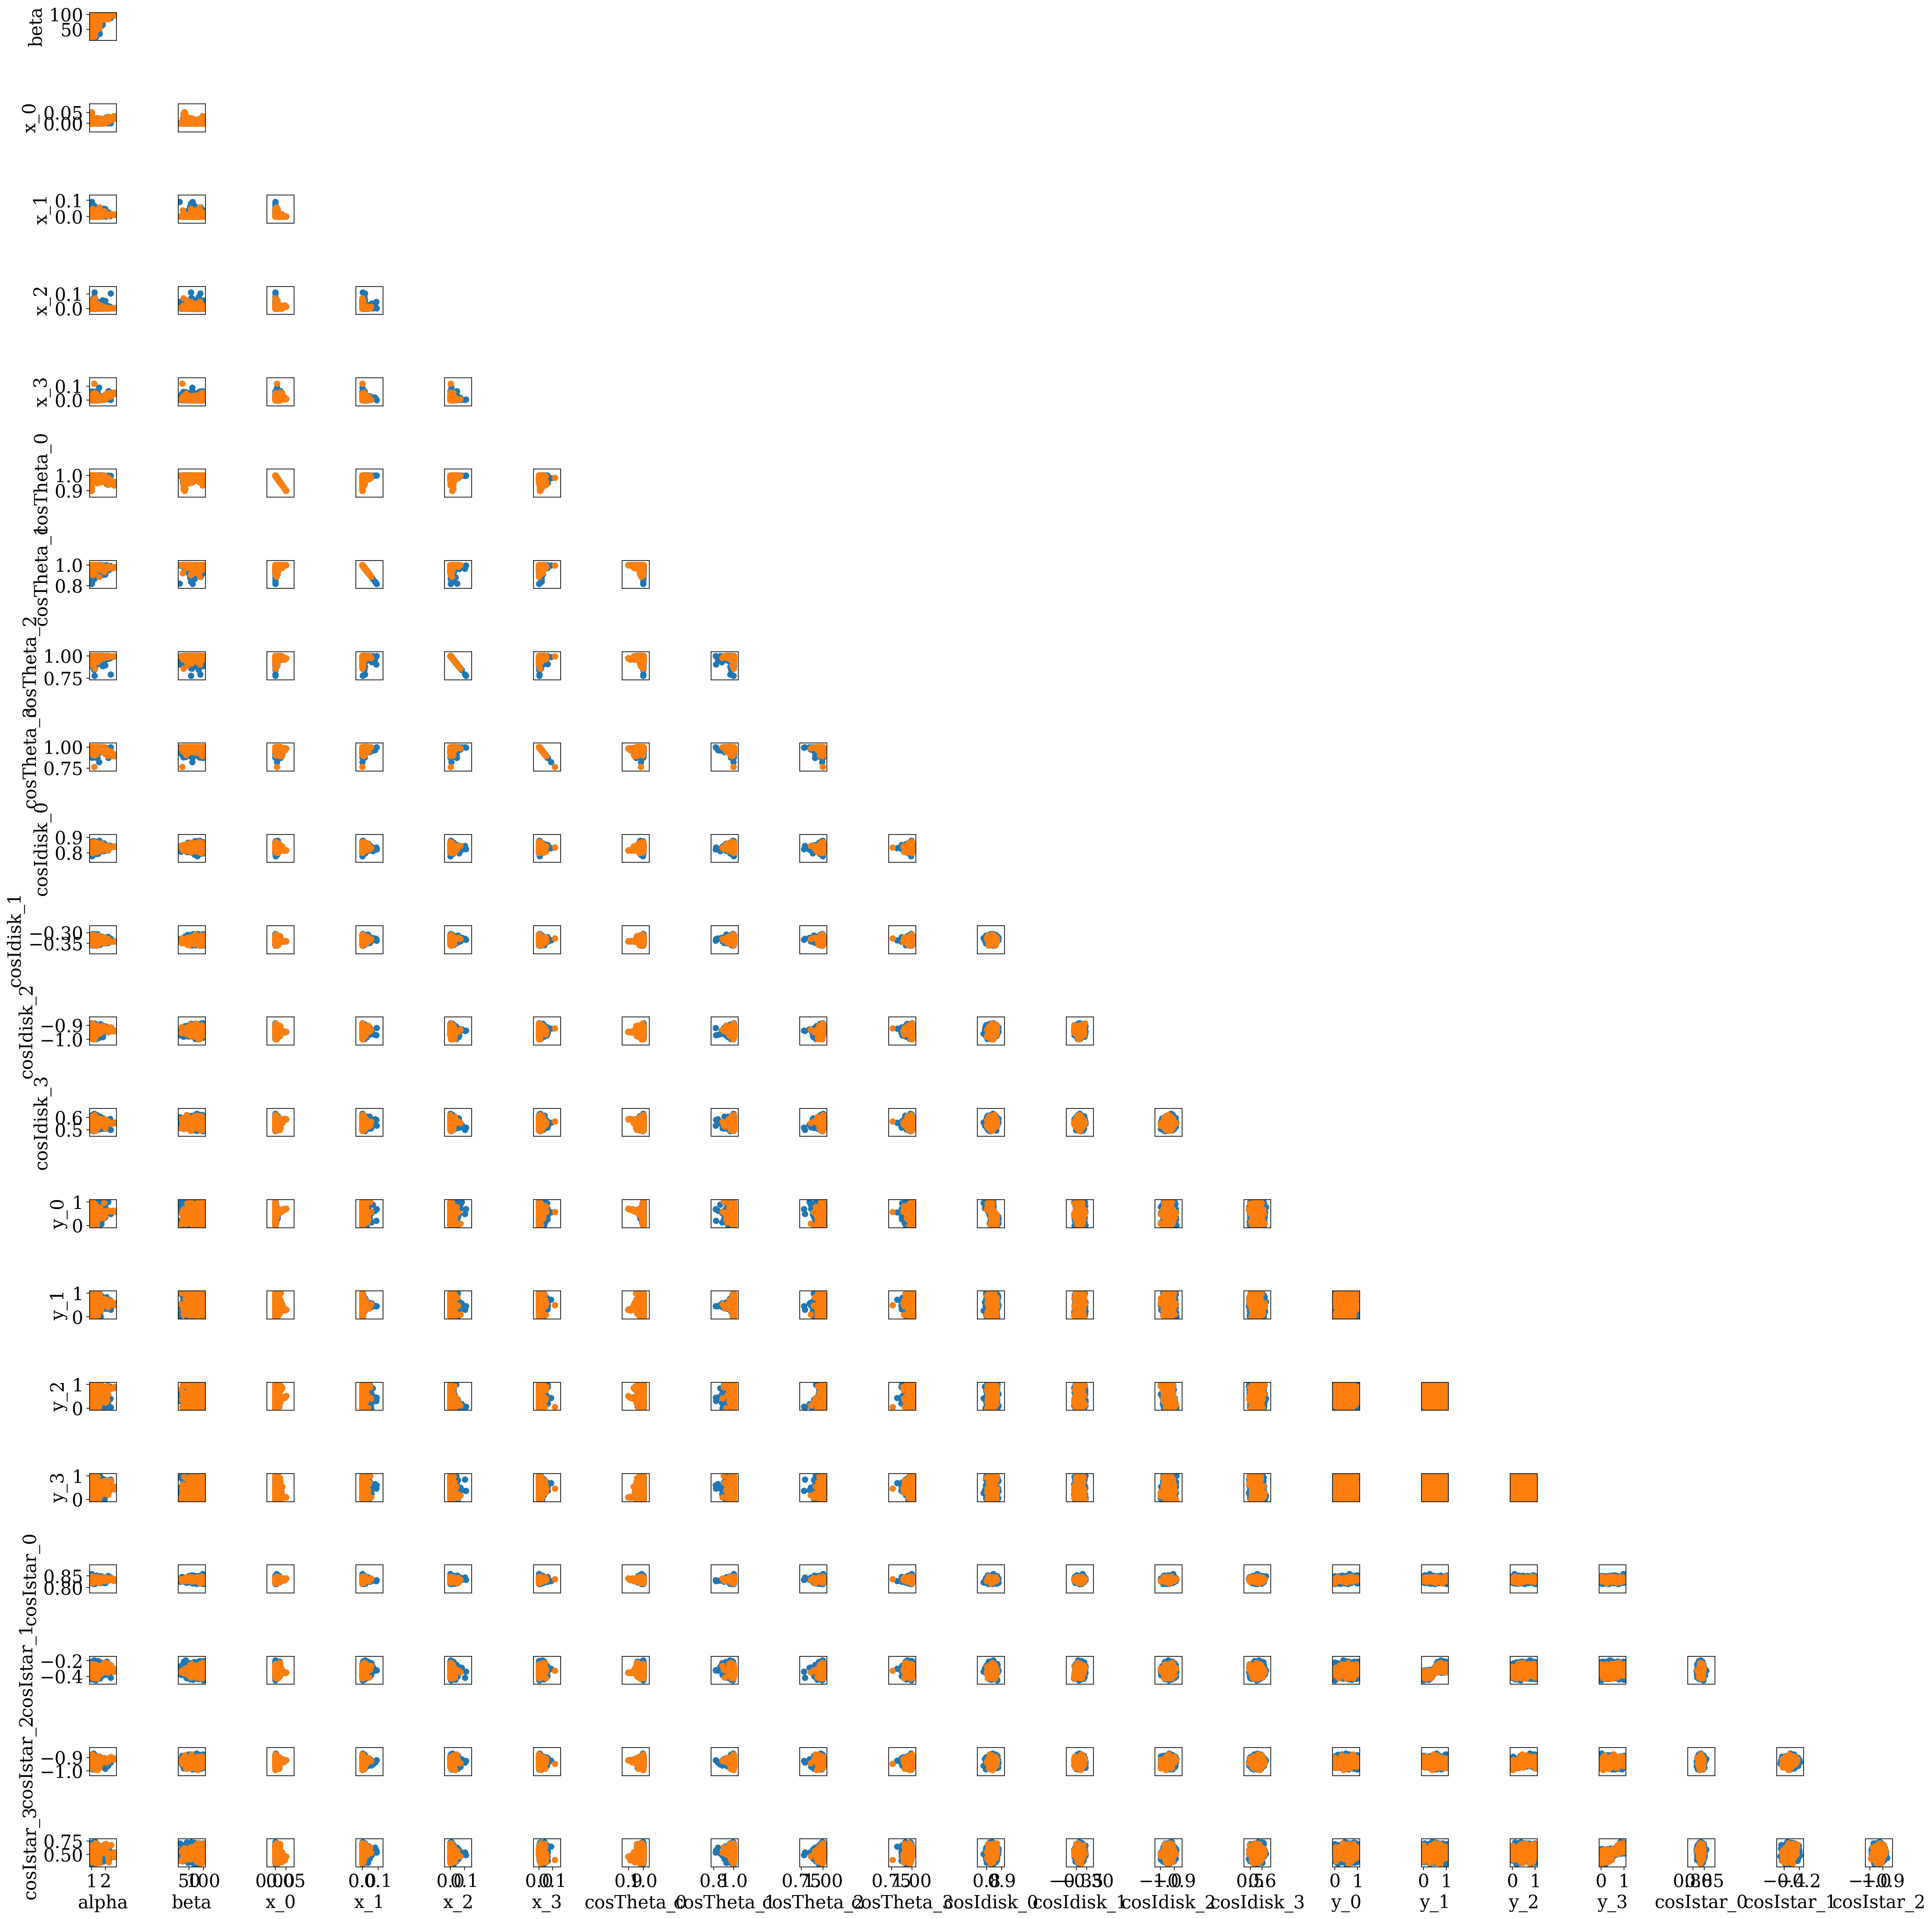

In [18]:
pm.pairplot(marginal_trace,
#             sub_varnames=["alpha", "beta", "x_0", "x_1", "x_2", "x_3", "y_0", "y_1", "y_2", "y_3"],
            divergences=True,
            color='C0',
            kwargs_divergence={'color': 'C1'})

This does a good job summarizing what is challenging about sampling this model. Even if we eliminate $\phi$ from the model, I think the sampling in $y$ or $\cos i_\star$ still becomes challenging. Maybe there is a better way to center $y$ on the mean value of $\cos i_\star$? But, basically, we see these difficult funnels to get in to, which probably explains why the posterior distributions for the isotropic model don't look as perfect as we might like.

In [124]:
pm.summary(marginal_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
log_alpha,0.106302,0.114828,0.001650,1.109778e-05,0.339022,3839.073976,0.999907
log_beta,3.807119,0.187901,0.002051,3.422968e+00,3.999876,8239.322887,0.999900
x__0,0.000119,0.000190,0.000003,9.221730e-12,0.000434,3462.654071,0.999914
x__1,0.000130,0.000198,0.000002,1.518994e-11,0.000459,6224.058452,1.000035
x__2,0.000138,0.000212,0.000003,2.923101e-11,0.000485,6480.876820,0.999901
x__3,0.000146,0.000263,0.000003,8.187307e-12,0.000499,6705.532571,1.000063
cos_theta__0,0.999762,0.000380,0.000006,9.991323e-01,1.000000,3462.654071,0.999914
cos_theta__1,0.999740,0.000397,0.000004,9.990814e-01,1.000000,6224.058452,1.000035
cos_theta__2,0.999725,0.000425,0.000006,9.990297e-01,1.000000,6480.876820,0.999901
cos_theta__3,0.999708,0.000525,0.000007,9.990022e-01,1.000000,6705.532571,1.000063
